In [1]:
import imageio
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
import os
from IPython.display import display, Image
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch.nn.functional as F
import torch
import yaml

def disp_im(im):
    plt.close()
    plt.cla()
    fig = plt.imshow(im)
    plt.close()
    display(fig.figure)

../log/noprednorms_nl0_conserve_pb0/car_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


/tmp/ipykernel_16612/4252541100.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_psnr': 13.246861882719719, 'envmap_psnr_top': 14.600082836477682, 'envmap_smape': 20.199839149511703, 'envmap_smape_top': 12.856912180421002}


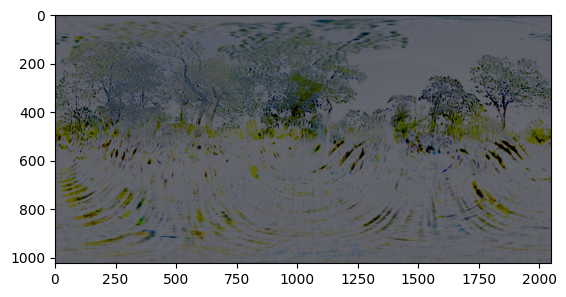

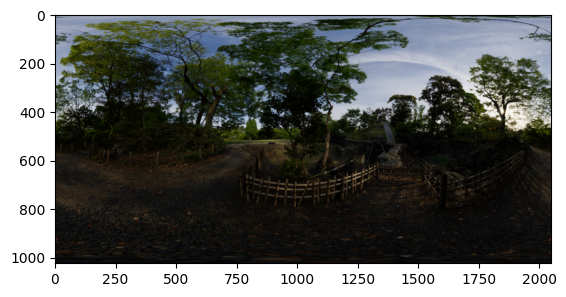

../log/noprednorms_nl0_conserve_pb0/mic_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_psnr': 14.015709854279905, 'envmap_psnr_top': 13.194491504210031, 'envmap_smape': 16.11949240445158, 'envmap_smape_top': 18.273553696594714}


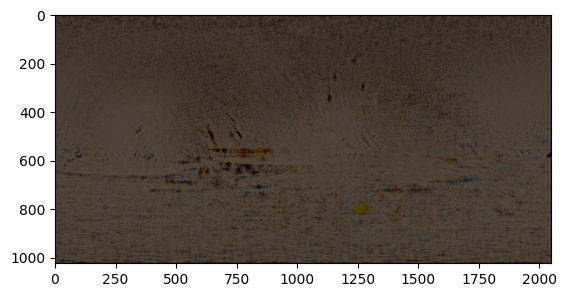

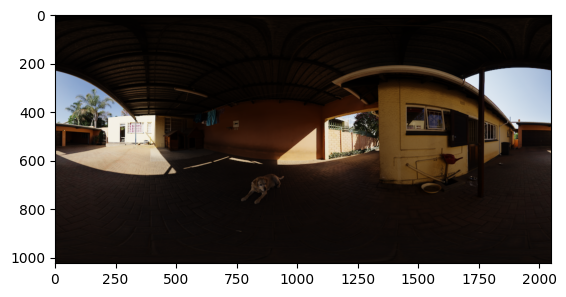

../log/noprednorms_nl0_conserve_pb0/helmet_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_noprednorms_nl0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_psnr': 18.49243073393859, 'envmap_psnr_top': 18.220651015278193, 'envmap_smape': 4.1641970247050555, 'envmap_smape_top': 4.243318799370008}


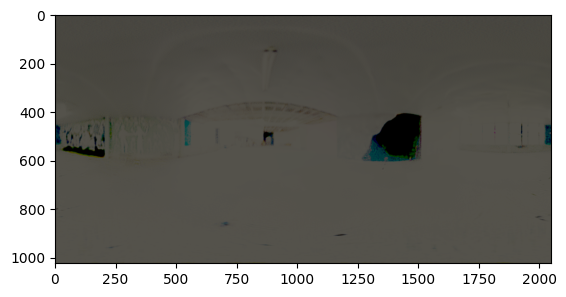

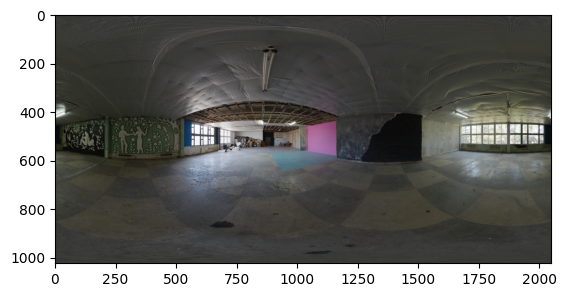

../log/noprednorms_nl0_conserve_pb0/teapot_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0
{'envmap_psnr': 14.37287252186323, 'envmap_psnr_top': 19.38634782441437, 'envmap_smape': 11.422852234323335, 'envmap_smape_top': 3.4220671919037673}


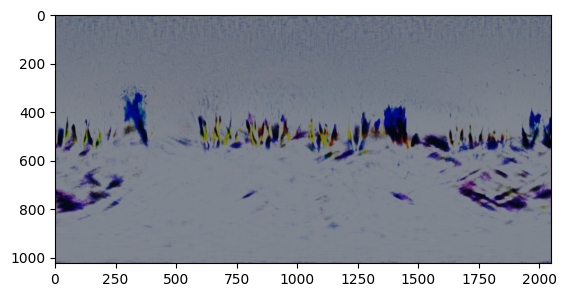

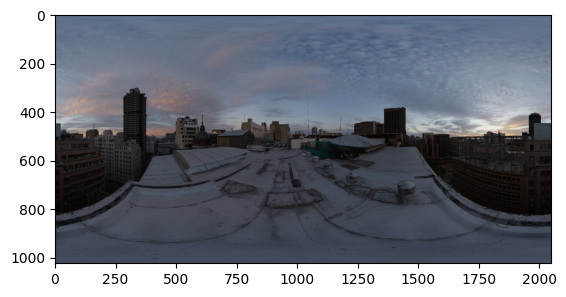

../log/noprednorms_nl0_conserve_pb0/materials_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_psnr': 15.825534853637855, 'envmap_psnr_top': 14.905822767622166, 'envmap_smape': 12.441659739300352, 'envmap_smape_top': 11.855662010490416}


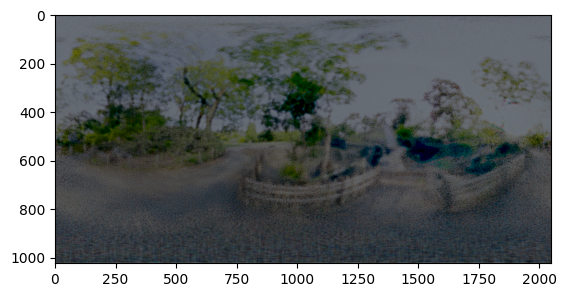

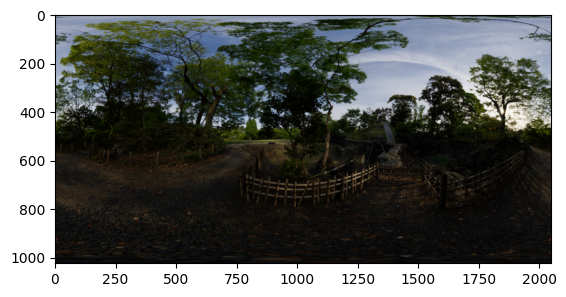

../log/noprednorms_nl0_conserve_pb0/shinyball_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_noprednorms_nl0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_psnr': 14.318037357771642, 'envmap_psnr_top': 14.300717811760656, 'envmap_smape': 16.39135320785818, 'envmap_smape_top': 13.013805955352328}


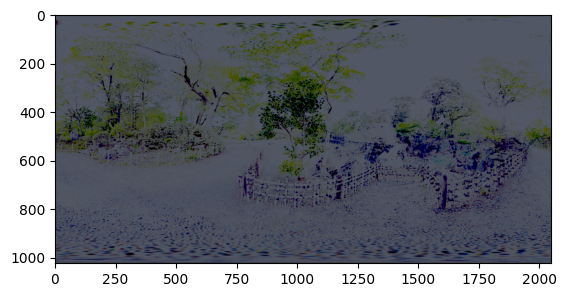

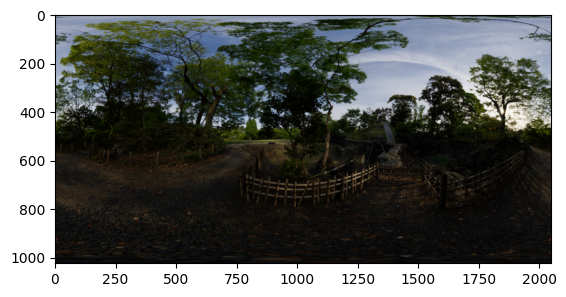

../log/noprednorms_nl0_conserve_pb0/ball_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_noprednorms_nl0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_psnr': 14.51488851142678, 'envmap_psnr_top': 13.253329034030191, 'envmap_smape': 15.583288272554894, 'envmap_smape_top': 15.66275283723068}


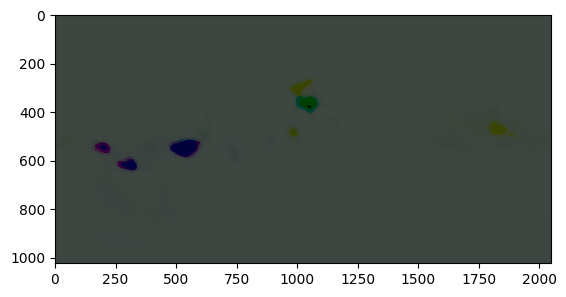

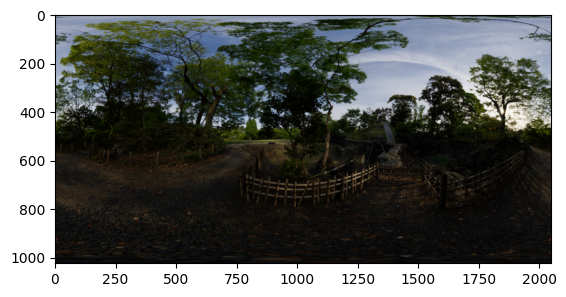

In [6]:
# log_dir = Path("../log") / "norussian"
# log_dir = Path("../log") / "noprednorms_nl0"
log_dir = Path("../log") / "noprednorms_nl0_conserve_pb0"
for p in log_dir.glob("*"):
    print(p)
    pano_path = p / "imgs_test_all" / "envmaps" / "pano.exr"
    mapped_pano_path = p / "imgs_test_all" / "envmaps" / "mapped_pano.png"
    old_data_path = p / "imgs_test_all" / "stats.yaml"
    new_data_path = p / "imgs_test_all" / "stats_aug.yaml"
    config = OmegaConf.load(p / 'config.yaml')
    if 'gt_bg' not in config['dataset'] or config['dataset']['gt_bg'] is None:
        continue
    gt_bg_path = Path("../backgrounds") / config['dataset']['gt_bg']
    pred_bg = imageio.imread(str(pano_path))
    gt_bg = cv.imread(str(gt_bg_path), -1)
    gt_bg = cv.cvtColor(gt_bg, cv.COLOR_BGR2RGB)
    fH = pred_bg.shape[0]
    fW = pred_bg.shape[1]
    resize_bg = F.interpolate(torch.as_tensor(gt_bg).permute(2, 0, 1).unsqueeze(0), (fH, fW)).squeeze(0).permute(1, 2, 0).numpy()

    flip_bg = resize_bg[:, ::-1] # flip
    flip_bg = np.concatenate([flip_bg[:, fW//2:], flip_bg[:, :fW//2]], axis=1)

    def f(x):
        x = np.clip(x, 0, 99)
        return x / (1+x)
    
    def f_inv(x):
        return -x/(x-1)

    sin_vals = np.sin(np.arange(fH) / fH * np.pi).reshape(-1, 1, 1)

    X = f((pred_bg * sin_vals)[:fH//2].reshape(-1, 3))
    Y = f((flip_bg * sin_vals)[:fH//2].reshape(-1, 3))
    fullX = f(pred_bg.reshape(-1, 3))

    B = np.mean(Y - X, axis=0)

    M = np.sum((X+B) * Y, axis=0) / np.sum((X+B)**2, axis=0)

    # model = linear_model.LinearRegression()
    # model.fit(X, Y)
    
    # fit_bg = model.predict(fullX).reshape(pred_bg.shape)
    fit_bg = (M*fullX+B).reshape(pred_bg.shape)
    imageio.imsave(mapped_pano_path, (np.clip(f_inv(fit_bg), 0, 1)*255).astype(np.uint8))



    err = (f(flip_bg) - fit_bg)**2 * sin_vals
    top_psnr = -10 * np.log(np.mean(err[:fH//2])) / np.log(10.0)
    psnr = -10 * np.log(np.mean(err)) / np.log(10.0)
    smape = np.mean(err / (np.abs(f(flip_bg)) + np.abs(fit_bg)) * 2) * 100
    smape_top = np.mean(err[:fH//2] / (np.abs(f(flip_bg)) + np.abs(fit_bg))[:fH//2] * 2) * 100
    data = dict(
        envmap_psnr=float(psnr),
        envmap_psnr_top=float(top_psnr),
        envmap_smape=float(smape),
        envmap_smape_top=float(smape_top),
    )
    print(data)


    disp_im(fit_bg)
    disp_im(f(flip_bg))
    with old_data_path.open('r') as f:
        old_data = yaml.safe_load(f)
    with new_data_path.open('w') as f:
        yaml.dump(dict(**data, **old_data), f)

In [3]:
print(pred_bg.dtype)
print(gt_bg.dtype)

float32
float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


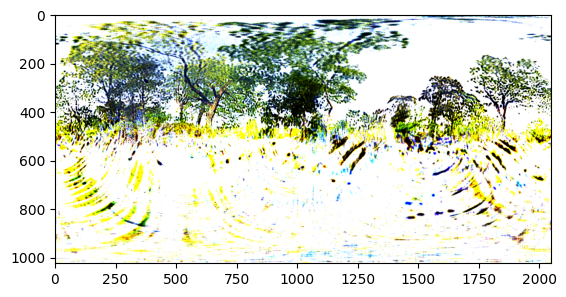

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


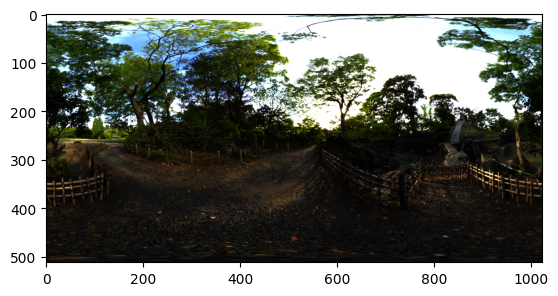

In [21]:
disp_im(pred_bg)
disp_im(gt_bg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17.826105848638683
11.994616662647893


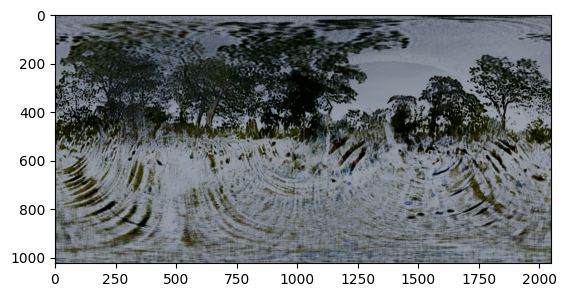

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


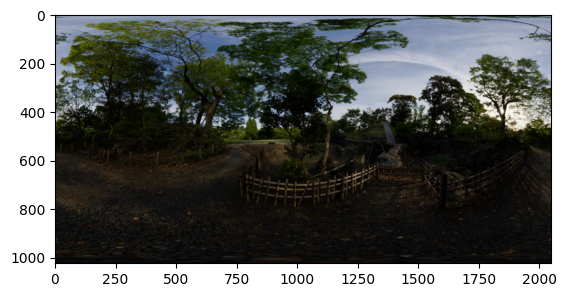